In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/PBRTQC'

/content/drive/MyDrive/Colab Notebooks/PBRTQC


In [5]:
#imports
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Collection
import numpy as np
from scipy import stats


In [52]:
df = pd.read_csv("creatinine.csv")
df.head()

,Day,Result
0,1,53.0
1,1,60.0
2,1,52.0
3,1,814.0
4,2,115.0


In [54]:
mid_day = df['Day'].max()*0.8
train = df[df['Day'] <= mid_day]
test = df[df['Day'] > mid_day]


# Apply the Box-Cox transformation
transformed_train, lambda_value = stats.boxcox(train['Result'])
train = pd.DataFrame({
    'Day': train['Day'],
    'Result': transformed_train
})

# Apply the Box-Cox transformation
transformed_test = stats.boxcox(test['Result'], lmbda=lambda_value)
test = pd.DataFrame({
    'Day': test['Day'],
    'Result': transformed_test
})

test_1 = test.copy()
ref = pd.concat([train, test_1], axis=0)

print(mid_day)
print(train.shape)
print(test.shape)


72.8
(50699, 2)
(14506, 2)


In [55]:
no_bias_total = 300  # Set the amount of result with no bias in a day
def simulation(x, bias):
  if len(x) >= no_bias_total:
          x.iloc[no_bias_total:] *= (1 + bias)
  return x

# Plotting Helper Functions


In [56]:
def plot_each_day_result (final):
  for day, group in final.groupby('Day'):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(group.index, group['Result'], label='Original Result', color='c')
    plt.plot(group.index, group['MA'], label='Moving Average', color='black')
    plt.axhline(y=group['UCL'].iloc[0], label='Upper Control Limit', linestyle='--', color='red')
    plt.axhline(y=group['LCL'].iloc[0], label='Lower Control Limit', linestyle='--', color='green')

    # Plot red dots for anomalies
    anomalies = group[group['Anomaly'] == True]
    plt.scatter(anomalies.index, anomalies['Result'], color='red', label='Anomaly')

    plt.title(f'Day {day} - Moving Average')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all (final):
  # Create a single figure
  plt.figure(figsize=(10, 6))

  # Plot lines for 'Result', 'MA', 'UCL', and 'LCL'
  plt.plot(final.index, final['Result'], label='Original Result', color='c')
  plt.plot(final.index, final['MA'], label='Moving Average', color='black')
  plt.axhline(y=final['UCL'].iloc[0], label='Upper Control Limit', linestyle='--', color='red')
  plt.axhline(y=final['LCL'].iloc[0], label='Lower Control Limit', linestyle='--', color='green')

  # Plot red dots for anomalies
  anomalies = final[final['Anomaly'] == True]
  plt.scatter(anomalies.index, anomalies['Result'], color='red', label='Anomaly')

  # Set title, labels, legend, and grid
  plt.title('Moving Average')
  plt.xlabel('Data Point Index')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)

  # Show the plot
  plt.show()

# Moving Average

In [20]:
def calculate_control_limits(data, num_std_dev = 1.5):
    mean = np.mean(data)
    std_dev = np.std(data)

    # Calculate the upper and lower control limits
    ucl = mean + (num_std_dev * std_dev)
    lcl = mean - (num_std_dev * std_dev)

    return ucl, lcl

In [67]:
def test_simulation (bias_value, cl_threshold, window_size, train, test):
  ucl, lcl = calculate_control_limits(train['Result'], cl_threshold)


  test['Result'] = test.groupby('Day')['Result'].transform(lambda x: simulation(x, bias_value))

  final = pd.concat([train, test], axis=0)

  final['MA'] = final['Result'].rolling(window = window_size).mean()
  # final['MA'] = final.groupby('Day')['Result'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
  final['UCL'] = ucl
  final['LCL'] = lcl

  final['Anomaly'] = (final['MA'] > final['UCL']) | (final['MA'] < final['LCL'])
  anomalies = final[final['Anomaly'] == True]

  return ucl, lcl, final, anomalies

In [27]:
def evaluation(final, ref):
  final['Actual'] = final['Result'] != ref['Result']
  final['Actual'] = final['Actual'].astype(bool)

  # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
  truth_table_test = final[final['Day'] > mid_day]

  TP = ((truth_table_test['Actual'] == True) & (truth_table_test['Anomaly'] == True)).sum()
  TN = ((truth_table_test['Actual'] == False) & (truth_table_test['Anomaly'] == False)).sum()
  FP = ((truth_table_test['Actual'] == False) & (truth_table_test['Anomaly'] == True)).sum()
  FN = ((truth_table_test['Actual'] == True) & (truth_table_test['Anomaly'] == False)).sum()

  # Calculate Specificity, Sensitivity, Accuracy, FPR, and FNR
  specificity = TN / (TN + FP)
  sensitivity = TP / (TP + FN)
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  FPR = FP / (FP + TN)
  FNR = FN / (FN + TP)

  # Print the calculated metrics
  print ("Test Bias (%):", bias)
  print("Specificity:", specificity)
  print("Sensitivity:", sensitivity)
  print("Accuracy:", accuracy)
  print("False Positive Rate (FPR):", FPR)
  print("False Negative Rate (FNR):", FNR)

# Results

In [70]:
bias = 0.2
threshold = 3
window_size = 50
test = test_1.copy()
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): 0.2
Specificity: 0.8991228070175439
Sensitivity: 0.9659323188734954
Accuracy: 0.9396801323590238
False Positive Rate (FPR): 0.10087719298245613
False Negative Rate (FNR): 0.034067681126504656


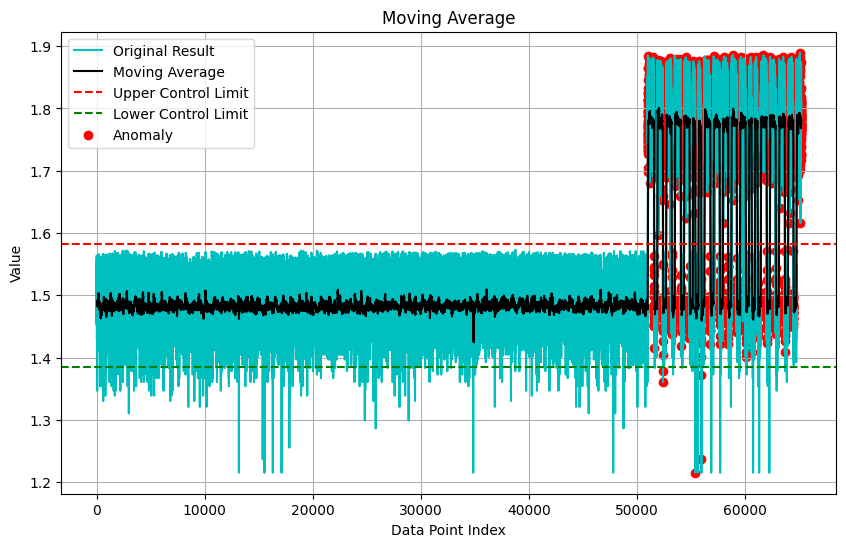

In [71]:
plot_all(final)

In [72]:
plot_each_day_result(final)


Output hidden; open in https://colab.research.google.com to view.

In [73]:
bias = -0.2
threshold = 3
window_size = 50
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): -0.2
Specificity: 0.8933333333333333
Sensitivity: 0.9644560526913468
Accuracy: 0.9365090307458982
False Positive Rate (FPR): 0.10666666666666667
False Negative Rate (FNR): 0.03554394730865319


In [74]:
bias = 0.1
threshold = 3
window_size = 50
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): 0.1
Specificity: 0.9533333333333334
Sensitivity: 0.9309561662502839
Accuracy: 0.9397490693506135
False Positive Rate (FPR): 0.04666666666666667
False Negative Rate (FNR): 0.06904383374971611


In [75]:
bias = -0.1
threshold = 3
window_size = 50
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): -0.1
Specificity: 0.9440350877192982
Sensitivity: 0.9276629570747218
Accuracy: 0.9340962360402592
False Positive Rate (FPR): 0.05596491228070175
False Negative Rate (FNR): 0.07233704292527822


In [76]:
bias = 0.05
threshold = 3
window_size = 50
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): 0.05
Specificity: 1.0
Sensitivity: 0.0
Accuracy: 0.39294085206121604
False Positive Rate (FPR): 0.0
False Negative Rate (FNR): 1.0


In [77]:
bias = -0.05
threshold = 3
window_size = 50
test = test_1.copy() # take back the original test
ucl, lcl, final, anomalies = test_simulation(bias, threshold, window_size, train, test)
evaluation(final, ref)

Test Bias (%): -0.05
Specificity: 1.0
Sensitivity: 0.0
Accuracy: 0.39294085206121604
False Positive Rate (FPR): 0.0
False Negative Rate (FNR): 1.0
